In [136]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis

import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [3]:
df = pd.read_csv('lyrics_data/all_lyrics.csv', index_col = 0)


FileNotFoundError: File b'lyrics_data/all_lyrics.csv' does not exist

In [131]:
text_corpus = df.text.values.tolist()
text_corpus = [re.sub('\S*@\S*\s?', '', doc) for doc in text_corpus] #removing email addresses
text_corpus = [re.sub('\s+', ' ', doc) for doc in text_corpus] #removing newline characters
text_corpus = [re.sub("\'", "", doc) for doc in text_corpus] #removing single quote characters


In [132]:
warnings.simplefilter("ignore", DeprecationWarning)

def doc_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

words = list(doc_to_words(text_corpus))

In [133]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
 
def remove_stopwords(text):
    return [[word for word in gensim.utils.simple_preprocess(str(doc)) if word not in stop_words] for doc in text_corpus]
 
words = remove_stopwords(words)

In [134]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
 
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for idx, sent in enumerate(texts):
        if (idx) % 500 == 0:
            print(str(idx) + ' documents lemmatised')
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out
 
data_lemmatized = lemmatization(words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

0 documents lemmatised


In [7]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           per_word_topics=True)
        model_list.append(lda_model)
        coherencemodel = CoherenceModel(model= lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

NameError: name 'id2word' is not defined

In [12]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

NameError: name 'x' is not defined

In [135]:
import gensim.corpora as corpora
id2word = corpora.Dictionary(data_lemmatized)
 
# Create Corpus
corpus = [id2word.doc2bow(text) for text in data_lemmatized]
 
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=14, 
                                           per_word_topics=True)

In [136]:
doc_lda = lda_model[corpus]

In [137]:
doc_lda = lda_model[corpus]
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/Users/Haebichan/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.039126 -0.020706       1        1  14.190208
12    -0.025749 -0.035613       2        1  12.039566
0     -0.040232 -0.022876       3        1  11.164268
1     -0.023822 -0.050528       4        1   9.429187
4     -0.004054 -0.006446       5        1   9.242455
9     -0.031241 -0.030441       6        1   8.270370
7      0.135271 -0.024974       7        1   7.198675
6     -0.031520  0.035950       8        1   6.676804
2     -0.014077  0.067462       9        1   5.852489
8     -0.022951  0.012453      10        1   5.677946
5      0.065349 -0.004916      11        1   3.377448
13    -0.003216 -0.035403      12        1   3.031745
11     0.063514  0.047915      13        1   2.131322
10    -0.028146  0.068123      14        1   1.717521, topic_info=     Category        Freq       Term       Total  loglift  logprob
term                                                              
67    Default  228.000000      dance  228.000000  30.0000  30.0000
58    Default  363.000000       baby  363.000000  29.0000  29.0000
172   Default  195.000000        run  195.000000  28.0000  28.0000
85    Default  570.000000       love  570.000000  27.0000  27.0000
25    Default  460.000000        get  460.000000  26.0000  26.0000
142   Default  274.000000        day  274.000000  25.0000  25.0000
135   Default  121.000000       call  121.000000  24.0000  24.0000
17    Default  182.000000      dream  182.000000  23.0000  23.0000
2907  Default   64.000000  shakalaka   64.000000  22.0000  22.0000
2347  Default   72.000000       boom   72.000000  21.0000  21.0000
192   Default  329.000000       come  329.000000  20.0000  20.0000
101   Default   58.000000        pop   58.000000  19.0000  19.0000
125   Default  186.000000      wanna  186.000000  18.0000  18.0000
963   Default  103.000000       song  103.000000  17.0000  17.0000
2901  Default   50.000000  fantastic   50.000000  16.0000  16.0000
26    Default  645.000000         go  645.000000  15.0000  15.0000
464   Default   67.000000       burn   67.000000  14.0000  14.0000
72    Default  282.000000       feel  282.000000  13.0000  13.0000
1341  Default   40.000000   converse   40.000000  12.0000  12.0000
38    Default  120.000000        not  120.000000  11.0000  11.0000
2900  Default   41.000000    dadance   41.000000  10.0000  10.0000
0     Default  189.000000       away  189.000000   9.0000   9.0000
33    Default  313.000000        let  313.000000   8.0000   8.0000
266   Default  130.000000      crazy  130.000000   7.0000   7.0000
1     Default  106.000000         be  106.000000   6.0000   6.0000
550   Default   30.000000        gon   30.000000   5.0000   5.0000
1230  Default  258.000000       girl  258.000000   4.0000   4.0000
2797  Default   34.000000       holi   34.000000   3.0000   3.0000
1082  Default   38.000000       home   38.000000   2.0000   2.0000
4     Default   96.000000       blue   96.000000   1.0000   1.0000
...       ...         ...        ...         ...      ...      ...
871   Topic14    4.202414       high   80.792450   1.1081  -4.9536
744   Topic14    2.249381      color   34.977417   1.3202  -5.5786
192   Topic14    8.433181       come  329.841400   0.3979  -4.2571
2437  Topic14    1.910572      power   28.215136   1.3718  -5.7419
52    Topic14    2.722030       wake   52.625381   1.1025  -5.3879
132   Topic14    5.125415       back  173.863358   0.5402  -4.7550
603   Topic14    1.849012      trust   29.101368   1.3082  -5.7746
238   Topic14    3.902638       pass  120.265472   0.6362  -5.0276
25    Topic14    7.270990        get  460.906525  -0.0850  -4.4054
784   Topic14    3.280953   everyone   91.449883   0.7366  -5.2011
55    Topic14    3.528907      world  126.750557   0.4831  -5.1283
34    Topic14    3.344971       life  124.942017   0.4439  -5.1818
693   Topic14    2.110183      dirty   43.023438   1.0493  -5.6425
35    Topic

In [138]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=text_corpus):
    # Array of top 10 topics
    top10array = []
 
    for row in range(ldamodel.num_topics):
        wp = ldamodel.show_topic(row)
        topic_keywords = ", ".join([word for word, prop in wp])
        top10array.append((row+1, topic_keywords))
 
    top10dict = dict(top10array)
 
    sent_topics_df = pd.DataFrame(pd.DataFrame([sorted(topic[0], key=lambda x: (x[1]), reverse=True) for topic in ldamodel[corpus]])[0])
    sent_topics_df.columns=["Data"]
    sent_topics_df['Dominant_Topic'] = sent_topics_df.Data.apply(lambda x: x[0]+1)
    sent_topics_df['Perc_Contribution'] = sent_topics_df.Data.apply(lambda x: round(x[1],4))
    sent_topics_df['Topic_Keywords'] = sent_topics_df.Dominant_Topic.apply(lambda x: top10dict[x])
 
    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents.rename("Text")], axis=1)
    sent_topics_df = sent_topics_df[['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 'Text']]
    return(sent_topics_df)
 
df_topic_sents_keywords = format_topics_sentences()

In [139]:
df_topic_sents_keywords

,Dominant_Topic,Perc_Contribution,Topic_Keywords,Text
0,10,0.5672,"love, get, know, even, go, want, good, make, f...",you’re the sun that rose again in my life a r...
1,8,0.9764,"dance, baby, go, wanna, shakalaka, boom, fanta...",if you ask me about that moment bright sunshi...
2,13,0.9931,"go, love, away, heart, still, come, time, fall...",at first sight i could recognize you as if we...
3,7,0.9918,"run, get, go, love, let, time, heart, feel, ev...",you hide but only appear when you smile where...
4,10,0.9952,"love, get, know, even, go, want, good, make, f...",is this love is this love sometimes i know so...
5,13,0.4508,"go, love, away, heart, still, come, time, fall...",the world is a complex we wus lookin for love...
6,13,0.9879,"go, love, away, heart, still, come, time, fall...",a sound of something breaking i awake from sl...
7,10,0.9960,"love, get, know, even, go, want, good, make, f...",for you i could pretend like i was happy when...
8,13,0.9917,"go, love, away, heart, still, come, time, fall...",full of loneliness this garden bloomed full o...
9,2,0.9953,"go, get, want, let, baby, good, love, time, ho...",it was a good start in itself before i knew i...


In [141]:
sent_topics_sorteddf = pd.DataFrame()
 
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')
 
for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)
 
# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)
 
# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
 
# Show
sent_topics_sorteddf.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,1,0.9955,"want, love, say, get, know, day, look, really,...",your converse high your converse high your co...
1,2,0.9962,"go, get, want, let, baby, good, love, time, ho...",stop for a moment if we keep this up we wont ...
2,3,0.9964,"song, pop, know, stop, look, go, need, baby, r...",hey swag swag whatever they say i’m here for ...
3,4,0.9961,"girl, know, go, get, need, let, good, love, da...",on top of this ending tune i am standing here...
4,5,0.9950,"go, get, feel, heart, come, even, want, day, l...",somebody call me right one somebody call me w...


In [149]:
sent_topics_sorteddf.Keywords[6]

'run, get, go, love, let, time, heart, feel, even, say'

In [21]:
kpop_df = pd.read_csv('data/merged_kpop_song_features.csv', index_col = 0)
kpop_df = kpop_df.rename(columns = {'song_name_formatted':'name'})

In [22]:
df_topic_sents_keywords['name'] = df.name

In [23]:
merged_df = pd.merge(kpop_df, df_topic_sents_keywords, on = 'name')

In [24]:
merged_df['target'] = [1 if i == 'BTS' else 0 for i in merged_df.artist_name]

In [25]:
merged_df = merged_df['Dominant_Topic Perc_Contribution Topic_Keywords name artist_name target'.split()]

In [26]:
merged_df = merged_df.drop_duplicates()

In [27]:
pd.crosstab(merged_df.target, merged_df.Dominant_Topic)

Dominant_Topic,1,2,3,4,5,6,7,8,9,10,11,12,13,14
target,,,,,,,,,,,,,,
0,5,2,5,5,1,27,6,4,3,5,4,7,4,2
1,5,4,11,1,2,6,4,3,10,6,5,9,6,2


# Guided LDA

In [45]:
from sklearn.feature_extraction.text import *

In [96]:
vectorizer = CountVectorizer(min_df=5, stop_words = 'english')

In [97]:
features = vectorizer.fit_transform(df.text).toarray()
labels = df.target
features.shape

(207, 782)

In [98]:
len(vectorizer.vocabulary_)

782

In [99]:
import guidedlda

In [101]:
vocab = vectorizer.vocabulary_

In [116]:
X = guidedlda.datasets.load_data(guidedlda.datasets.NYT)
vocab = guidedlda.datasets.load_vocab(guidedlda.datasets.NYT)

In [122]:
model = guidedlda.GuidedLDA(n_topics=5, n_iter=100, random_state=7, refresh=20)

In [123]:
model.fit(features)

In [119]:
model.topic_word_

array([[9.77965084e-03, 8.98521811e-03, 3.20351322e-03, ...,
        3.67792932e-08, 7.35953657e-05, 1.76577387e-04],
       [7.86317324e-08, 9.27933074e-04, 2.04521136e-04, ...,
        1.88794789e-04, 1.73068443e-04, 2.36681514e-05],
       [2.15456191e-03, 6.04247804e-04, 9.97680992e-04, ...,
        1.07772591e-04, 6.56190353e-05, 6.09353068e-05],
       [1.22506801e-03, 1.78604709e-04, 3.82083685e-04, ...,
        9.55520659e-05, 3.32625836e-05, 4.15263215e-08],
       [2.60618331e-04, 1.36813087e-03, 4.78024671e-03, ...,
        4.34590092e-05, 5.97459583e-05, 6.51749414e-05]])

In [121]:
model.topic_word_[0]

array([9.77965084e-03, 8.98521811e-03, 3.20351322e-03, ...,
       3.67792932e-08, 7.35953657e-05, 1.76577387e-04])

In [124]:
topic_word = model.topic_word_

In [95]:
n_top_words = 8

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

IndexError: too many indices for array

In [68]:
for i, topic_dist in enumerate(topic_word):
    print(i,topic_dist)


0 [9.77965084e-03 8.98521811e-03 3.20351322e-03 ... 3.67792932e-08
 7.35953657e-05 1.76577387e-04]
1 [7.86317324e-08 9.27933074e-04 2.04521136e-04 ... 1.88794789e-04
 1.73068443e-04 2.36681514e-05]
2 [2.15456191e-03 6.04247804e-04 9.97680992e-04 ... 1.07772591e-04
 6.56190353e-05 6.09353068e-05]
3 [1.22506801e-03 1.78604709e-04 3.82083685e-04 ... 9.55520659e-05
 3.32625836e-05 4.15263215e-08]
4 [2.60618331e-04 1.36813087e-03 4.78024671e-03 ... 4.34590092e-05
 5.97459583e-05 6.51749414e-05]


# Korean Lyrics

In [160]:
from sklearn.metrics import *
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from catboost import CatBoostClassifier, Pool, cv
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence
import shap
from itertools import combinations


In [161]:
df = pd.read_csv('lyrics_data/Korean_lyrics/merged_original_kpop_lyrics.csv', index_col = 0)

In [162]:
# gensim modules
import gensim
from gensim import utils
from gensim.models.doc2vec import LabeledSentence
from gensim.models import Doc2Vec, Word2Vec

# numpy
import numpy

# classifier
from sklearn.linear_model import LogisticRegression

# random
import random

In [163]:

# Tweaking the LabeledLineSentence class to allow separation of labels and a list of words for multiple files

class LabeledLineSentence(object):
    def __init__(self, sources):
        self.sources = sources
        
        flipped = {}
        
        # make sure that keys are unique
        for key, value in sources.items():
            if value not in flipped:
                flipped[value] = [key]
            else:
                raise Exception('Non-unique prefix encountered')
    
    def __iter__(self):
        for source, prefix in self.sources.items():
            with utils.smart_open(source) as fin:
                for item_no, line in enumerate(fin):
                    yield LabeledSentence(utils.to_unicode(line).split(), [prefix + '_%s' % item_no])
    
    def to_array(self):
        self.sentences = []
        for source, prefix in self.sources.items():
            with utils.smart_open(source) as fin:
                for item_no, line in enumerate(fin):
                    self.sentences.append(LabeledSentence(utils.to_unicode(line).split(), [prefix + '_%s' % item_no]))
        return self.sentences
    
    def sentences_perm(self):
        shuffled = list(self.sentences)
        random.shuffle(shuffled)
        return shuffled

In [164]:
sources = {'lyrics_data/Korean_lyrics/korean_lyrics.txt':'kpop_lyrics'}

sentences = LabeledLineSentence(sources)

In [165]:
doc_model = Doc2Vec(min_count=1, window=10, size=150, sample=1e-4, negative=5, workers=7)

doc_model.build_vocab(sentences.to_array())
 
# doc_model.train(sentences.sentences_perm(), total_examples=doc_model.corpus_count, epochs= 2000)

# doc_model.save('data/korean_doc2vecmodel')

gensim_model = gensim.models.Doc2Vec.load('data/korean_doc2vecmodel')


/Users/Haebichan/anaconda3/lib/python3.6/site-packages/gensim/models/doc2vec.py:535: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [166]:
print(gensim_model.docvecs.most_similar(1))

[('kpop_lyrics_95', 0.6406261920928955), ('kpop_lyrics_277', 0.628616452217102), ('kpop_lyrics_90', 0.6270997524261475), ('kpop_lyrics_205', 0.6229199171066284), ('kpop_lyrics_73', 0.6170247793197632), ('kpop_lyrics_233', 0.6130409240722656), ('kpop_lyrics_108', 0.6108198165893555), ('kpop_lyrics_271', 0.6069984436035156), ('kpop_lyrics_194', 0.6055890917778015), ('kpop_lyrics_239', 0.6055294275283813)]


/Users/Haebichan/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [167]:
train_arrays = np.zeros((df.shape[0], gensim_model['kpop_lyrics_0'].shape[0]))
train_labels = np.array(df.target)

for i in range(df.text.shape[0]):
    train_arrays[i] = gensim_model['kpop_lyrics_' + str(i)]

In [168]:
x_train, x_test, y_train, y_test = train_test_split(train_arrays, train_labels, test_size = .2, random_state = 40)    

In [169]:
classifier = LogisticRegression()

classifier.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [170]:
y_pred = classifier.predict(x_test)

accuracy_score(y_test,y_pred)

0.847457627118644

In [171]:
lgb_model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.01,
                                   reg_alpha = 0.1, reg_lambda = 0.1, silent=True,
                                   subsample = 0.8, n_jobs = -1)
lgb_model.fit(x_train, y_train,
           eval_set=[(x_test, y_test)],
           early_stopping_rounds=10000,
eval_metric='auc',
verbose=200,)

Training until validation scores don't improve for 10000 rounds.
[200]	valid_0's auc: 0.856105	valid_0's binary_logloss: 0.455936
[400]	valid_0's auc: 0.911337	valid_0's binary_logloss: 0.359078
[600]	valid_0's auc: 0.925872	valid_0's binary_logloss: 0.329251
[800]	valid_0's auc: 0.93314	valid_0's binary_logloss: 0.326585
[1000]	valid_0's auc: 0.9375	valid_0's binary_logloss: 0.326253
[1200]	valid_0's auc: 0.940407	valid_0's binary_logloss: 0.324044
[1400]	valid_0's auc: 0.946221	valid_0's binary_logloss: 0.321768
[1600]	valid_0's auc: 0.947674	valid_0's binary_logloss: 0.319158
[1800]	valid_0's auc: 0.949128	valid_0's binary_logloss: 0.320406
[2000]	valid_0's auc: 0.950581	valid_0's binary_logloss: 0.320279
[2200]	valid_0's auc: 0.950581	valid_0's binary_logloss: 0.320504
[2400]	valid_0's auc: 0.950581	valid_0's binary_logloss: 0.320504
[2600]	valid_0's auc: 0.950581	valid_0's binary_logloss: 0.320504
[2800]	valid_0's auc: 0.950581	valid_0's binary_logloss: 0.320504
[3000]	valid_0's a

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=1.0, importance_type='split', learning_rate=0.01,
        max_depth=-1, min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=10000, n_jobs=-1, num_leaves=31,
        objective='binary', random_state=None, reg_alpha=0.1,
        reg_lambda=0.1, silent=True, subsample=0.8,
        subsample_for_bin=200000, subsample_freq=0)

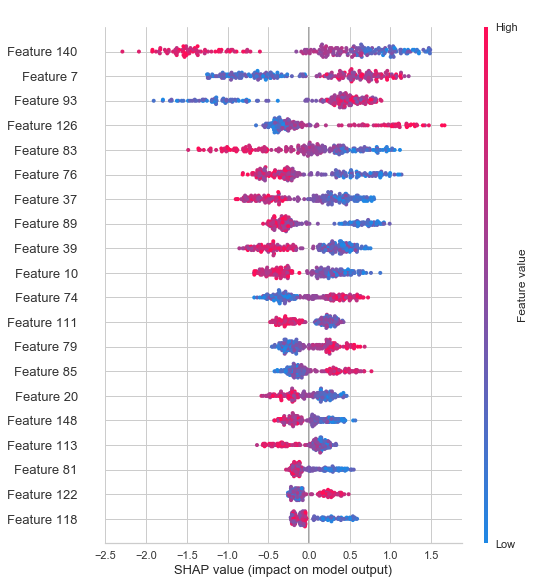

In [172]:
shap_explainer = shap.TreeExplainer(lgb_model)
shap_values = shap_explainer.shap_values(x_train)

shap.summary_plot(shap_values, x_train)

In [173]:
from yellowbrick.text import TSNEVisualizer
from sklearn.manifold import TSNE

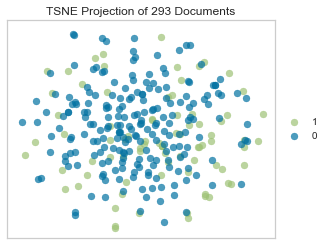

In [174]:
tsne = TSNEVisualizer()
tsne.fit(train_arrays, all_lyrics.target)
tsne.poof()

In [175]:
text_corpus = df.text.values.tolist()
text_corpus = [re.sub('\S*@\S*\s?', '', doc) for doc in text_corpus] #removing email addresses
text_corpus = [re.sub('\s+', ' ', doc) for doc in text_corpus] #removing newline characters
text_corpus = [re.sub("\'", "", doc) for doc in text_corpus] #removing single quote characters


In [176]:
warnings.simplefilter("ignore", DeprecationWarning)

def doc_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

words = list(doc_to_words(text_corpus))

In [177]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
 
def remove_stopwords(text):
    return [[word for word in gensim.utils.simple_preprocess(str(doc)) if word not in stop_words] for doc in text_corpus]
 
words = remove_stopwords(words)

In [178]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
 
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for idx, sent in enumerate(texts):
        if (idx) % 500 == 0:
            print(str(idx) + ' documents lemmatised')
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out
 
data_lemmatized = lemmatization(words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

0 documents lemmatised


In [184]:
import gensim.corpora as corpora
id2word = corpora.Dictionary(data_lemmatized)
 
# Create Corpus
corpus = [id2word.doc2bow(text) for text in data_lemmatized]
 
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           per_word_topics=True)

In [180]:
# def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
#     """
#     Compute c_v coherence for various number of topics

#     Parameters:
#     ----------
#     dictionary : Gensim dictionary
#     corpus : Gensim corpus
#     texts : List of input texts
#     limit : Max num of topics

#     Returns:
#     -------
#     model_list : List of LDA topic models
#     coherence_values : Coherence values corresponding to the LDA model with respective number of topics
#     """
#     coherence_values = []
#     model_list = []
#     for num_topics in range(start, limit, step):
#         lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
#                                            id2word=id2word,
#                                            num_topics=20, 
#                                            per_word_topics=True)
#         model_list.append(lda_model)
#         coherencemodel = CoherenceModel(model= lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
#         coherence_values.append(coherencemodel.get_coherence())

#     return model_list, coherence_values


# # Can take a long time to run.
# model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)
# # Show graph
# limit=40; start=2; step=6;
# x = range(start, limit, step)
# plt.plot(x, coherence_values)
# plt.xlabel("Num Topics")
# plt.ylabel("Coherence score")
# plt.legend(("coherence_values"), loc='best')
# plt.show()

In [187]:
doc_lda = lda_model[corpus]

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/Users/Haebichan/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.089966  0.017357       1        1  22.326597
2     -0.030551  0.061071       2        1  22.144436
1      0.000445 -0.063302       3        1  20.154467
3     -0.037175  0.000738       4        1  19.241507
4     -0.022685 -0.015864       5        1  16.133001, topic_info=      Category        Freq        Term       Total  loglift  logprob
term                                                                
8065   Default  139.000000        dumb  139.000000  30.0000  30.0000
43     Default  356.000000        baby  356.000000  29.0000  29.0000
8763   Default   53.000000      rookie   53.000000  28.0000  28.0000
10363  Default   83.000000         으르렁   83.000000  27.0000  27.0000
1952   Default  102.000000         run  102.000000  26.0000  26.0000
1380   Default   84.000000        talk   84.000000  25.0000  25.0000
7389   Default   28.000000        cuse   28.000000  24.0000  24.0000
49     Default  309.000000        love  309.000000  23.0000  23.0000
1373   Default   29.000000        head   29.000000  22.0000  22.0000
2173   Default   38.000000       sweet   38.000000  21.0000  21.0000
4719   Default   28.000000         유행가   28.000000  20.0000  20.0000
3904   Default   30.000000        rock   30.000000  19.0000  19.0000
215    Default  131.000000        know  131.000000  18.0000  18.0000
180    Default  182.000000        girl  182.000000  17.0000  17.0000
47     Default  165.000000         get  165.000000  16.0000  16.0000
7547   Default   24.000000       duper   24.000000  15.0000  15.0000
2344   Default   28.000000   butterfly   28.000000  14.0000  14.0000
7480   Default   22.000000        help   22.000000  13.0000  13.0000
8720   Default   33.000000         zoo   33.000000  12.0000  12.0000
4275   Default   28.000000        home   28.000000  11.0000  11.0000
48     Default  106.000000         let  106.000000  10.0000  10.0000
5595   Default   19.000000    twilight   19.000000   9.0000   9.0000
428    Default  123.000000        good  123.000000   8.0000   8.0000
50     Default   22.000000         pop   22.000000   7.0000   7.0000
7677   Default   21.000000      cherry   21.000000   6.0000   6.0000
4361   Default   54.000000          기대   54.000000   5.0000   5.0000
4182   Default   33.000000       dirty   33.000000   4.0000   4.0000
1924   Default   40.000000        back   40.000000   3.0000   3.0000
2963   Default   25.000000        cool   25.000000   2.0000   2.0000
2168   Default   85.000000         boy   85.000000   1.0000   1.0000
8065    Topic1  138.511642        dumb  139.618256   1.4914  -4.0381
4719    Topic1   27.993793         유행가   28.696417   1.4746  -5.6371
7547    Topic1   23.441431       duper   24.159712   1.4692  -5.8146
8890    Topic1    8.450988      lalala    9.071499   1.4285  -6.8348
8889    Topic1    6.942149     dracula    7.562034   1.4139  -7.0315
2173    Topic1   34.506927       sweet   38.547600   1.3887  -5.4279
6633    Topic1    8.681273         죽겠다    9.819115   1.3762  -6.8079
4275    Topic1   24.677395        home   28.029383   1.3720  -5.7632
2170    Topic1    3.923647        evil    4.543074   1.3528  -7.6020
4716    Topic1    3.907683        어디서든    4.543437   1.3487  -7.6061
8245    Topic1    3.169647          않죠    3.788318   1.3211  -7.8154
7031    Topic1    3.169328        깜짝깜짝    3.788326   1.3210  -7.8155
7047    Topic1    3.169148        자릿자릿    3.788335   1.3209  -7.8156
9213    Topic1    7.440260         지나갈    9.102410   1.2978  -6.9622
4277    Topic1   11.767521        must   14.436239   1.2950  -6.5037
8899    Topic1    4.261249          숨어    5.303914   1.2805  -7.5195
8900    Topic1    2.414517         안기는    3.033597   1.2711  -8.0876
7549    Topic1    2.407032       굴었다가도    3.033093   1.2682  -8.0907
7557    Topic1    2.406237        취향이야    3.033046   1.2679  -8.0910
7550    Topic1    2.404712        남자처럼    3.032957   1.2673 

In [185]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=text_corpus):
    # Array of top 10 topics
    top10array = []
 
    for row in range(ldamodel.num_topics):
        wp = ldamodel.show_topic(row)
        topic_keywords = ", ".join([word for word, prop in wp])
        top10array.append((row+1, topic_keywords))
 
    top10dict = dict(top10array)
 
    sent_topics_df = pd.DataFrame(pd.DataFrame([sorted(topic[0], key=lambda x: (x[1]), reverse=True) for topic in ldamodel[corpus]])[0])
    sent_topics_df.columns=["Data"]
    sent_topics_df['Dominant_Topic'] = sent_topics_df.Data.apply(lambda x: x[0]+1)
    sent_topics_df['Perc_Contribution'] = sent_topics_df.Data.apply(lambda x: round(x[1],4))
    sent_topics_df['Topic_Keywords'] = sent_topics_df.Dominant_Topic.apply(lambda x: top10dict[x])
 
    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents.rename("Text")], axis=1)
    sent_topics_df = sent_topics_df[['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 'Text']]
    return(sent_topics_df)
 
df_topic_sents_keywords = format_topics_sentences()

In [186]:
df_topic_sents_keywords[:5]

,Dominant_Topic,Perc_Contribution,Topic_Keywords,Text
0,3,0.9896,"love, get, baby, talk, girl, rookie, fall, crazy, wanna, zoo",너는 내 삶에 다시 뜬 햇빛 어린 시절 내 꿈들의 재림 모르겠어 이 감정이 뭔지 혹시 여기도 꿈속인 건지 꿈은 사막의 푸른 신기루 내 안 깊은 곳의 a priori 숨이 ...
1,3,0.9951,"love, get, baby, talk, girl, rookie, fall, crazy, wanna, zoo",내게 그 순간을 묻는다면 환하게 내리쬔 sunshine 그 느낌을 묻는다면 자연스레 내 눈에 one shot 그 분위기 속 음악을 틀고 각자의 스트레칭 긴장은 풀려 지금 ...
2,4,0.9933,"run, love, good, go, get, boy, baby, head, rock, cuse",첫눈에 널 알아보게 됐어 서롤 불러왔던 것처럼 내 혈관 속 dna가 말해줘 내가 찾아 헤매던 너라는 걸 우리 만남은 수학의 공식 종교의 율법 우주의 섭리 내게 주어진 운명...
3,1,0.9921,"baby, dumb, go, come, sweet, love, 기대, want, know, back",꼭꼭 숨었다가 웃으면 나타나 어디서 온 걸까 거짓말하지마 천사가 맞잖아 니 정체가 뭐야 but you 그 미소는 잔인하다 못해 cruel 그 볼을 못 봤어야 해 you 사...
4,4,0.5982,"run, love, good, go, get, boy, baby, head, rock, cuse",is this love is this love sometimes i know sometimes i dont 이 다음 가사 음 뭐라고 쓸까 음 너무 많은 말이 날 돌지만 내...


In [188]:
sent_topics_sorteddf = pd.DataFrame()
 
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')
 
for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)
 
# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)
 
# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
 
# Show
sent_topics_sorteddf.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,1,0.9975,"baby, dumb, go, come, sweet, love, 기대, want, know, back",original dumb dumb dumb dumb dumb dumb dumb dumb dumb dumb dumb dumb dumb dumb dumb dumb dumb du...
1,2,0.9966,"girl, know, let, love, go, baby, 너의, need, beautiful, be","방탄소년단의 bts cypher 4 가사 이름, 이름 sorry bae 발음, 발음 sorry bae 딕션, 딕션, 딕션 sorry bae oh, face not an i..."
2,3,0.9959,"love, get, baby, talk, girl, rookie, fall, crazy, wanna, zoo",널 위해서라면 난 슬퍼도 기쁜 척 할 수가 있었어 널 위해서라면 난 아파도 강한 척 할 수가 있었어 사랑이 사랑만으로 완벽하길 내 모든 약점들은 다 숨겨지길 이뤄지지 않는...
3,4,0.9957,"run, love, good, go, get, boy, baby, head, rock, cuse",그대는 good good funny funny야 꿀이 뚝뚝 떨어지는 smile 막 초콜릿 녹여 놓은 eyes 그대는 good good funny funny good good...
4,5,0.9956,"으르렁, 내게, love, butterfly, feel, time, woo, crazy, get, baby","방탄소년단의 rain 가사 달리는 차들, 사방에 꿈틀대는 우산들 날씨는 흐림 공기는 맑음 연회색 배경의 난 왜 여기 멈춰 섰을까 생각이 많은 건지 없는 건지 잘 몰라 바깥..."


In [ ]:
##### 